In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent_date = most_recent_date[0]
most_recent_date

'2017-08-23'

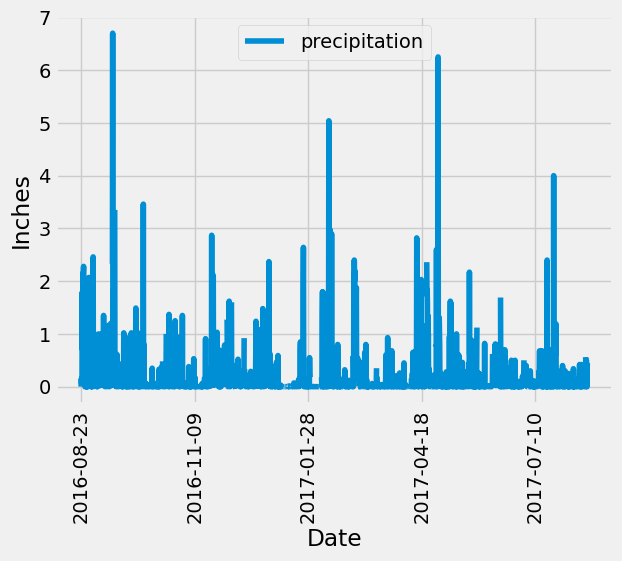

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='date', y='precipitation')
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Inches")

#plt.title("Precipitation Analysis (Last 12 Months)")
plt.show()

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
count = precipitation_df[['precipitation']].count()
mean = precipitation_df[['precipitation']].mean()
stddev = precipitation_df[['precipitation']].std()
minimum = precipitation_df[['precipitation']].min()
maximum = precipitation_df[['precipitation']].max()
quartiles = precipitation_df[['precipitation']].quantile([0.25, 0.5, 0.75])

summary_statistics = pd.DataFrame({
    'Precipitation': [count['precipitation'],
                      mean['precipitation'],
                      stddev['precipitation'], 
                      minimum['precipitation'],
                      quartiles.loc[0.25].values[0],
                      quartiles.loc[0.5].values[0],
                      quartiles.loc[0.75].values[0],
                      maximum['precipitation']]},
    index=['Count', 'Mean', 'Std Deviation', 'Minimum', '25%', '50%', '75%', 'Maximum'])

summary_statistics

,Precipitation
Count,2021.000000
Mean,0.177279
Std Deviation,0.461190
Minimum,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
Maximum,6.700000


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).all()
#print(f'Total number of stations: {total_stations}')
total_stations

[(9,)]

In [28]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()

# Print the results
print(active_stations)  

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
temperature_stats = session.query(func.min(measurement.tobs),
                                  func.max(measurement.tobs),
                                  func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station).all()

print(temperature_stats)

[(54.0, 85.0, 71.66378066378067)]


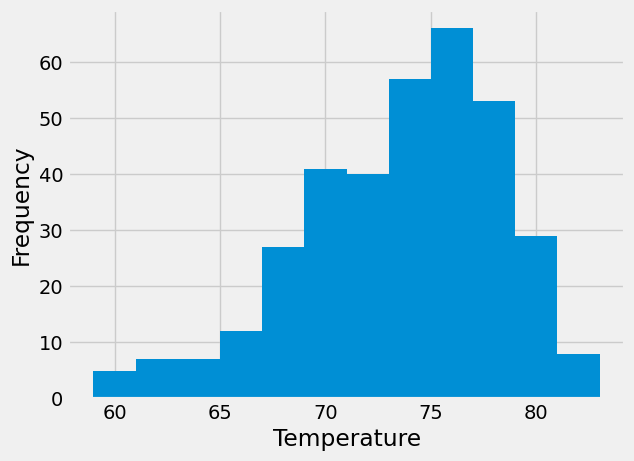

In [40]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == most_active_station).\
    filter(measurement.date >= one_year_ago).all()

temperature_df = pd.DataFrame(temperature_data, columns=['date', 'tobs'])

plt.hist(temperature_df['tobs'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [38]:
# Close Session
session.close()